In [8]:
import os
import numpy as np
from PIL import Image

# Paths
gt_dir = "/mnt/md126/users/mohamed/projects/AM/Data/Processed/Noisy_Pseudo_Masks/Andrii_12102024/masks_GT/"
base_pred_dir = "/mnt/md126/users/mohamed/projects/AM/Data/Processed/Noisy_Pseudo_Masks/Andrii_12102024/sam_temp/"
datasets = {
    "d0": "noisy_unique_idCIRP_ew8r3_d0/pred",
    "d1": "noisy_unique_idCIRP_ew8r3_d1/pred",
    "d2": "noisy_unique_idCIRP_ew8r3_d2/pred"
}

# Define splits
train_indices = list(range(30, 151, 30))   # [30, 60, 90, 120, 150]
val_indices = [180, 210]
test_indices = list(range(240, 301, 30))   # [240, 270, 300]

def load_binary_mask(path):
    """Load image and return binary mask (boolean numpy array)."""

    img = Image.open(path).convert("L")
    arr = np.array(img)
    # Assuming non-zero pixels are foreground
    mask = arr > 0
    return mask

def compute_iou(mask1, mask2):
    """Compute IoU between two boolean masks."""
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0.0
    return intersection / union

def get_gt_mask_for_index(index, dataset_key):
    # Extract the numeric part from the dataset key (e.g., "d0" -> "0")
    dataset_index = dataset_key[1]
    base_str = f"{index:05d}"
    fname = os.path.join(gt_dir, f"{base_str}_{dataset_index}.png")
    if os.path.exists(fname):
        return load_binary_mask(fname)
    else: 
        return None

def get_pred_mask_for_index(pred_dir, index):
    fname = os.path.join(pred_dir, f"{index:012d}.png")
    #if os.path.exists(fname):
    return load_binary_mask(fname)
    #return None

# Initialize results dictionary to hold mean IoUs
results = {
    "d0": {"train": None, "val": None, "test": None},
    "d1": {"train": None, "val": None, "test": None},
    "d2": {"train": None, "val": None, "test": None},
}

for dkey, dsubpath in datasets.items():
    pred_dir = os.path.join(base_pred_dir, dsubpath)
    
    for split, indices in [("train", train_indices),
                           ("val", val_indices),
                           ("test", test_indices)]:
        ious = []
        for idx in indices:
            gt_mask = get_gt_mask_for_index(idx, dkey)
            if gt_mask is None:
                # Skip if no GT mask
                continue
            pred_mask = get_pred_mask_for_index(pred_dir, idx)



            iou = compute_iou(gt_mask, pred_mask)
            ious.append(iou)
        
        if len(ious) > 0:
            mean_iou = sum(ious) / len(ious)
        else:
            mean_iou = 0.0
        
        results[dkey][split] = mean_iou

# Print results in a table
header = f"{'Dataset':<5} | {'Train':>10} | {'Val':>10} | {'Test':>10}"
print(header)
print("-" * len(header))
for dkey in ["d0", "d1", "d2"]:
    print(f"{dkey:<5} | {results[dkey]['train']:10.4f} | {results[dkey]['val']:10.4f} | {results[dkey]['test']:10.4f}")


Dataset |      Train |        Val |       Test
----------------------------------------------
d0    |     0.9273 |     0.8701 |     0.8801
d1    |     0.9254 |     0.8992 |     0.8219
d2    |     0.8856 |     0.7092 |     0.8716


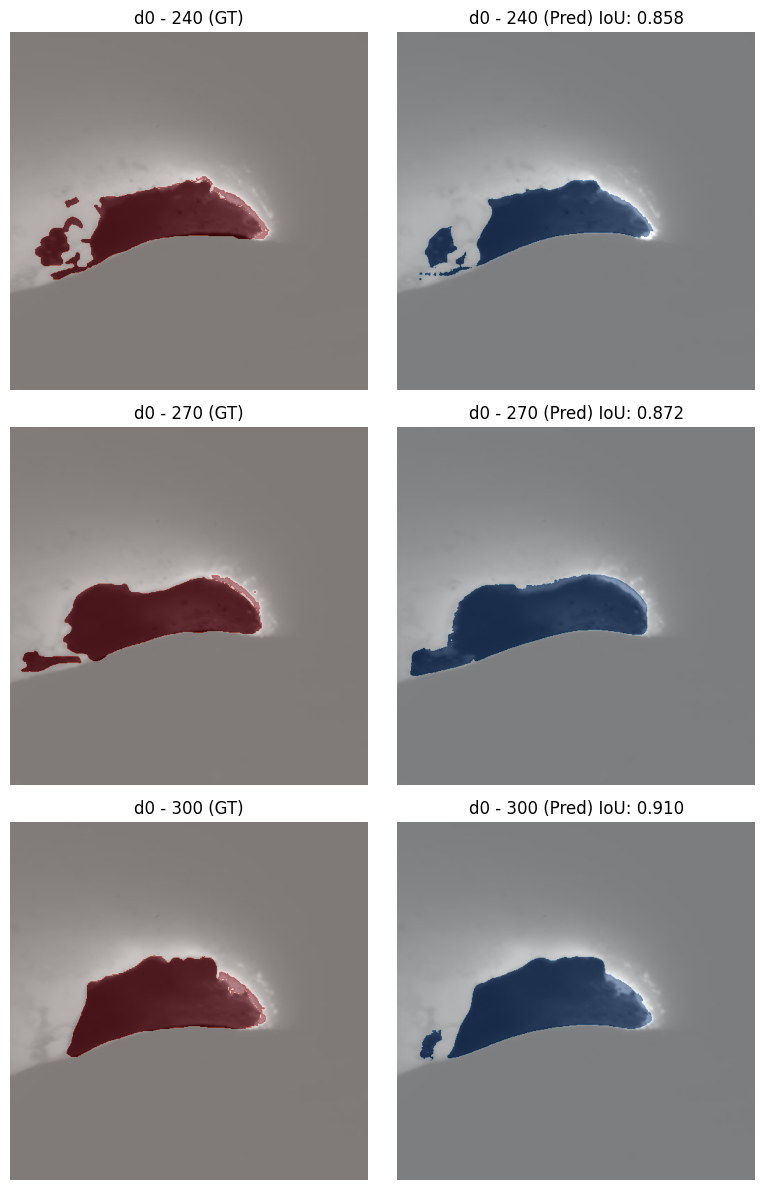

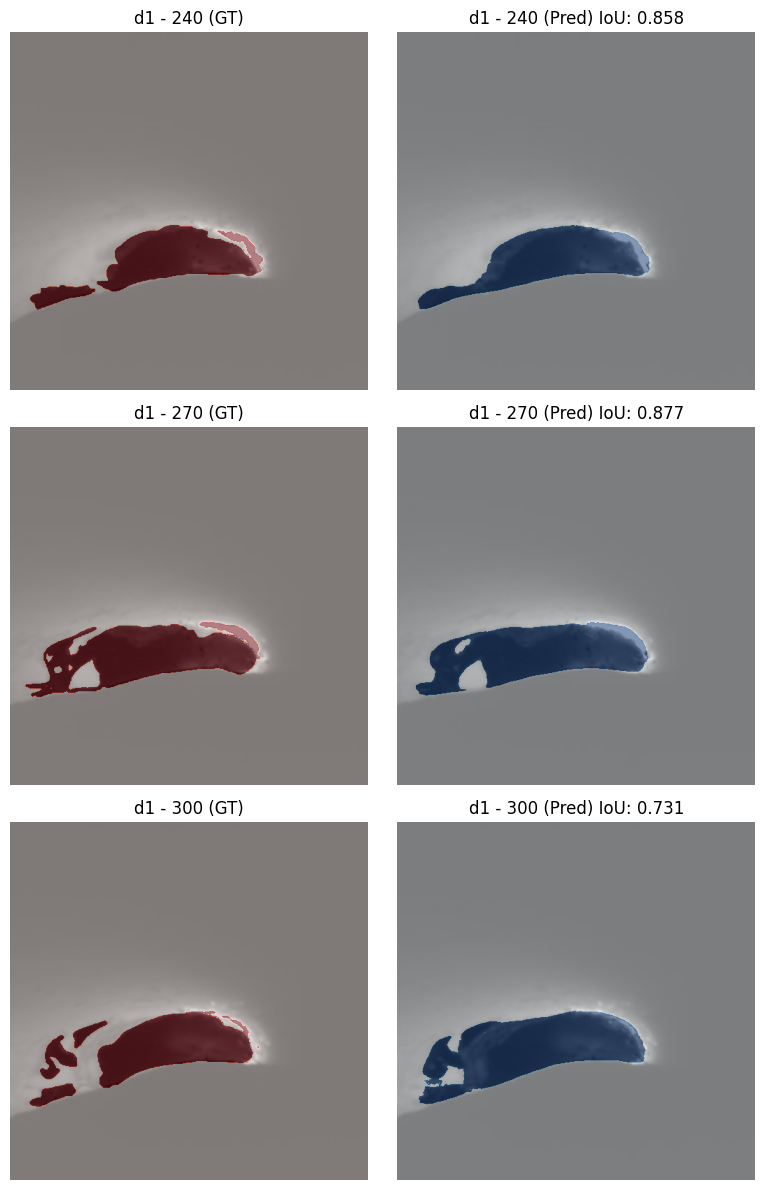

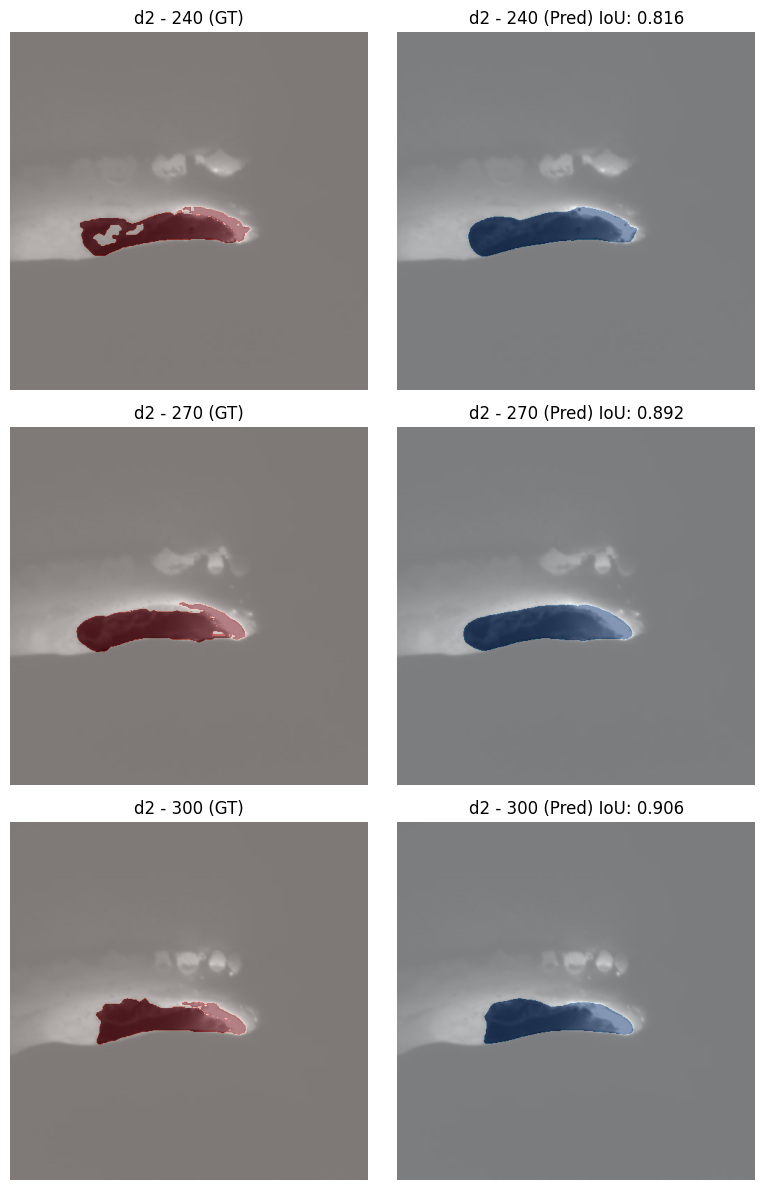

In [10]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Directories
gt_dir = "/mnt/md126/users/mohamed/projects/AM/Data/Processed/Noisy_Pseudo_Masks/Andrii_12102024/masks_GT/"
base_pred_dir = "/mnt/md126/users/mohamed/projects/AM/Data/Processed/Noisy_Pseudo_Masks/Andrii_12102024/sam_temp/"
datasets = {
    "d0": "noisy_unique_idCIRP_ew8r3_d0",
    "d1": "noisy_unique_idCIRP_ew8r3_d1",
    "d2": "noisy_unique_idCIRP_ew8r3_d2"
}

# Test indices
test_indices = [240, 270, 300]

def load_binary_mask(path):
    if not os.path.exists(path):
        return None
    img = Image.open(path).convert("L")
    arr = np.array(img)
    mask = arr > 0
    return mask

def compute_iou(gt_mask, pred_mask):
    intersection = np.logical_and(gt_mask, pred_mask).sum()
    union = np.logical_or(gt_mask, pred_mask).sum()
    if union == 0:
        return 0.0
    return intersection / union

def get_gt_mask_for_index(index, dataset_key):
    dataset_index = dataset_key[1]  # "d0" -> "0"
    base_str = f"{index:05d}"
    fname = os.path.join(gt_dir, f"{base_str}_{dataset_index}.png")
    if os.path.exists(fname):
        return load_binary_mask(fname)
    else:
        return None

def get_pred_mask_for_index(index, dataset_key):
    pred_dir = os.path.join(base_pred_dir, datasets[dataset_key], "pred")
    fname = os.path.join(pred_dir, f"{index:012d}.png")
    if os.path.exists(fname):
        return load_binary_mask(fname)
    else:
        return None

def get_raw_image_for_index(index, dataset_key):
    # Adjust the indexing or naming if needed. Currently assuming the raw images 
    # are named with 5-digit indexing and located in the 'raw' folder.
    index = index - 1  # if the raw images are 1-based indexing
    raw_dir = os.path.join(base_pred_dir, datasets[dataset_key], "raw")
    fname = os.path.join(raw_dir, f"{index:05d}.png")
    if not os.path.exists(fname):
        fname = os.path.join(raw_dir, f"{index:05d}.jpg")
        if not os.path.exists(fname):
            return None
    img = Image.open(fname).convert("RGB")
    return np.array(img)

# Generate one figure per dataset
for dkey in datasets.keys():
    fig, axes = plt.subplots(len(test_indices), 2, figsize=(8, 12))
    # 3 rows (for 3 images), 2 cols (GT overlay / pred overlay)

    for row, idx in enumerate(test_indices):
        # Load raw image
        raw_img = get_raw_image_for_index(idx, dkey)
        if raw_img is None:
            # If no raw image, just skip
            for col in range(2):
                axes[row, col].axis('off')
            continue

        # Load GT and Pred masks
        gt_mask = get_gt_mask_for_index(idx, dkey)
        pred_mask = get_pred_mask_for_index(idx, dkey)

        # Left column: GT overlay
        ax_gt = axes[row, 0]
        ax_gt.imshow(raw_img)
        if gt_mask is not None:
            ax_gt.imshow(gt_mask, cmap='Reds', alpha=0.5)
        ax_gt.set_title(f"{dkey} - {idx} (GT)")
        ax_gt.axis('off')

        # Right column: Pred overlay with IoU if both masks exist
        ax_pred = axes[row, 1]
        ax_pred.imshow(raw_img)
        iou_str = ""
        if gt_mask is not None and pred_mask is not None:
            ax_pred.imshow(pred_mask, cmap='Blues', alpha=0.5)
            iou_val = compute_iou(gt_mask, pred_mask)
            iou_str = f" IoU: {iou_val:.3f}"
        elif pred_mask is not None:
            # Only pred mask is available
            ax_pred.imshow(pred_mask, cmap='Blues', alpha=0.5)

        ax_pred.set_title(f"{dkey} - {idx} (Pred){iou_str}")
        ax_pred.axis('off')

    fig.tight_layout()
    plt.show()
